In [10]:
import pickle

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score, average_precision_score, auc, roc_curve, precision_recall_curve

%matplotlib inline

from utils import imgio as iio
_ENBL_ITR = [1, 101, 201, 1001, 5001, 10001, 
             15001, 20001, 25001, 30001, 35001, 
             40001, 45001, 50001, 60001, 70001, 
             80000, 80001, 90000, 90001]

_ENBL_ITR = [20001, 25001, 30001, 35001, 
             40001, 45001]

_ENBL_ITR = [20001, 25001]

_ENBL_ITR = [ 1001, 10001, 15001, 20001, 25000,
             25001, 30001, 35001, 40000, 40001,
             45001, 50001, 60001, 70001, 
             80000, 80001, 90000, 90001,
             100000
            ]


In [11]:
def get_pix_metrics_bin(GT, PR):
    """
    Args:
        GT (np.ndarray, bool): GT binary mask
        PR (np.ndarray, bool): prediction binary mask
    Returns:
        TBD
    """
    TP = GT*PR
    
    nTot = GT.size
    nGT = GT.sum()
    nPR = PR.sum()
    nTP = TP.sum()
    
    nFP = nPR - nTP
    nFN = nGT - nTP
    nTN = nTot - nTP - nFP - nFN
    
    P = (nTP/nPR) if nPR else 0.
    R = (nTP/nGT) if nGT else 0.
    A = (nTP+nTN)/nTot
    F1 = (2*P*R/((P+R))) if (P+R) else 0.
    F2 = (5*P*R/((4*P+R))) if (P+R) else 0.
    D = 2*nTP/(nGT+nPR) if (nGT+nPR) else 0.
    IoU = (nTP/(nTP+nFP+nFN)) if (nTP+nFP+nFN) else 0.
    TPR = R
    FPR = (nFP/(nFP+nTN)) if (nFP+nTN) else 0.

    metr = {
        'P': P,
        'R': R,
        'A': A,
        'F1': F1,
        'F2': F2,
        'D': D,
        'IoU': IoU,
        'TPR': TPR,
        'FPR': FPR,
        #'nGT': nGT  # if 0 - the rest should be used with caution
    }
    # calc return all metrics
    
    return metr
    
def get_pix_metrics_p(gt_bin, pred, p):
    pred_bin = pred>= p
    return get_pix_metrics_bin(gt_bin, pred_bin)
    
def get_pix_metrics(gt_bin, pred):
    edge = np.power(10,np.linspace(-10, -1, 30, endpoint=False))
    P = np.array(
            list(edge)+
            list(np.arange(0.1, 0.95, 0.05))+
            list(1 - edge[::-1])
        )
    
    all_metr = {}
    for p in P:
        metr = get_pix_metrics_p(gt_bin, pred, p)
        all_metr[p] = metr
        
    return all_metr
    
def get_frame_pix_metrics(gt_cdc, pred_cdc, is_3D=False):
    if is_3D:
        gt_cell, gt_diap, gt_cntr = gt_cdc.transpose((3, 0, 1, 2))
        pred_cell, pred_diap, pred_cntr = pred_cdc.transpose((3, 0, 1, 2))
    else:
        gt_cell, gt_diap, gt_cntr = gt_cdc.transpose((2, 0, 1))
        pred_cell, pred_diap, pred_cntr = pred_cdc.transpose((2, 0, 1))
    
    gt_cell, gt_diap = gt_cell>0.5, gt_diap>0.5
    
    cell_metr = get_pix_metrics(gt_cell, pred_cell)
    diap_metr = get_pix_metrics(gt_diap, pred_diap)
    return cell_metr, diap_metr

In [12]:
def get_pix_metr(val_summ):
    preds = val_summ['pred']
    tr_its = list(preds.keys())

    gt = val_summ['gt']
    n_z = len(gt)

    pix_metr = {}
    for tr_it in tr_its:
        if tr_it not in _ENBL_ITR:
            continue
        pred = preds[tr_it]

        pix_metr_it = pix_metr[tr_it] = {}
        for stack_idx, (pred_i, gt_i) in enumerate(zip(pred, gt)):
            print(f'get_pix_metr it:{tr_it} stack:{stack_idx}', end='\r')
            pix_metr_it_st = pix_metr_it[stack_idx] = {}
            cell_metr, diap_metr = get_frame_pix_metrics(gt_i, pred_i)
            pix_metr_it_st['cell'] = cell_metr
            pix_metr_it_st['diap'] = diap_metr
    return pix_metr

def get_cell_diap_tot(val_summ):
    gt_cdc = val_summ['gt']
    gt_cell, gt_diap, gt_cntr = gt_cdc.transpose((3, 0, 1, 2))
    gt_cell, gt_diap = gt_cell>0.5, gt_diap>0.5
    
    n_tot = gt_cell.size
    n_cell = gt_cell.sum()
    n_diap = gt_diap.sum()
    
    return n_cell, n_diap, n_tot
    

In [13]:
def get_mean_pix_metr(pix_metr):
    mean_pix_metr = {}
    for tr_it, pix_metr_it in pix_metr.items():
        mean_pix_metr_it = mean_pix_metr[tr_it] = {}
        st_0 = list(pix_metr_it.keys())[0]
        P = list(pix_metr_it[st_0]['cell'].keys())
        pars = list(pix_metr_it[st_0]['cell'][P[0]].keys())
        
        for tp in ['cell', 'diap']:
            mean_pix_metr_it[tp] = {}
            for p in P:
                mean_pix_metr_it[tp][p] = {}
                for par in pars:
                    arr = [metr[tp][p][par] for metr in pix_metr_it.values()]
                    mean_pix_metr_it[tp][p][par] = np.mean(arr)
    return mean_pix_metr

In [14]:
def get_mean_pix_metr_full(val_summ):
    mean_pix_metr = {}
    
    preds = val_summ['pred']
    tr_its = list(preds.keys())

    gt = val_summ['gt']
    n_z = len(gt)

    for tr_it in tr_its:
        print(f'get_mean_pix_metr_full it:{tr_it}', end='\r')
        if tr_it not in _ENBL_ITR:
            continue
        pred = preds[tr_it]

        mean_pix_metr_it = mean_pix_metr[tr_it] = {}
        cell_metr, diap_metr = get_frame_pix_metrics(gt, pred, is_3D=True)
        mean_pix_metr_it['cell'] = cell_metr
        mean_pix_metr_it['diap'] = diap_metr
        
    return mean_pix_metr

In [15]:
def auc_rec(x, y):
    _x = np.array(x)
    _y = np.array(y)
    f = -1 if (_x[0]>_x[-1]) else 1
    return f*((_x[1:]-_x[:-1])*_y[1:]).sum()

In [16]:
def get_pix_metr_agg(val_summ, mean_pix_metr, cell_frac, diap_frac):
    preds = val_summ['pred']
    tr_its = list(preds.keys())

    gt = val_summ['gt']
    n_z = len(gt)

    pix_metr_agg = {}
    for tr_it in tr_its:
        if tr_it not in _ENBL_ITR:
            continue
        print(f'get_pix_metr_agg it:{tr_it} ', end='\r')
        pred = preds[tr_it]
        pix_metr_agg_it = pix_metr_agg[tr_it] = {'cell':{}, 'diap':{}}

        # commented slow and w/ similar results skl impl.
        if False: 
            gt_cell, gt_diap, gt_cntr = gt.transpose((3, 0, 1, 2))

            pred_cell, pred_diap, pred_cntr = pred.transpose((3, 0, 1, 2))
            roc_auc_cell = roc_auc_score(gt_cell.ravel(), pred_cell.ravel())
            roc_auc_diap = roc_auc_score(gt_diap.ravel(), pred_diap.ravel())

            pr_auc_cell = average_precision_score(gt_cell.ravel(), pred_cell.ravel())
            pr_auc_diap = average_precision_score(gt_diap.ravel(), pred_diap.ravel())

            roc_c_cell = roc_curve(gt_cell.ravel(), pred_cell.ravel())  # fpr, tpr, t
            roc_c_diap = roc_curve(gt_diap.ravel(), pred_diap.ravel())

            pr_c_cell = precision_recall_curve(gt_cell.ravel(), pred_cell.ravel())  # p, r, t
            pr_c_diap = precision_recall_curve(gt_diap.ravel(), pred_diap.ravel())

            pix_metr_agg_it['cell']['roc_auc'] = roc_auc_cell
            pix_metr_agg_it['diap']['roc_auc'] = roc_auc_diap

            pix_metr_agg_it['cell']['ap'] = pr_auc_cell
            pix_metr_agg_it['diap']['ap'] = pr_auc_diap

            pix_metr_agg_it['cell']['roc_c'] = roc_c_cell
            pix_metr_agg_it['diap']['roc_c'] = roc_c_diap

            pix_metr_agg_it['cell']['pr_c'] = pr_c_cell
            pix_metr_agg_it['diap']['pr_c'] = pr_c_diap
        
            fpr, tpr, thresholds = roc_c_cell
            pix_metr_agg_it['cell']['roc_c_auc_t'] = auc(fpr, tpr)
            pix_metr_agg_it['cell']['roc_c_auc_r'] = auc_rec(fpr, tpr)

            fpr, tpr, thresholds = roc_c_diap
            pix_metr_agg_it['diap']['roc_c_auc_t'] = auc(fpr, tpr)
            pix_metr_agg_it['diap']['roc_c_auc_r'] = auc_rec(fpr, tpr)

            p, r, thresholds = pr_c_cell
            pix_metr_agg_it['cell']['pr_c_auc_t'] = auc(r, p)
            pix_metr_agg_it['cell']['pr_c_auc_r'] = auc_rec(r, p)

            p, r, thresholds = pr_c_diap
            pix_metr_agg_it['diap']['pr_c_auc_t'] = auc(r, p)
            pix_metr_agg_it['diap']['pr_c_auc_r'] = auc_rec(r, p)
        
        pos_fracs = {'cell':cell_frac, 'diap':diap_frac}
        for tp in ['cell', 'diap']:
            frac = pos_fracs[tp]
            
            metr = mean_pix_metr[tr_it][tp]
            ps = list(metr.keys())
            P = [metr[p]['P'] for p in ps]
            R = [metr[p]['R'] for p in ps]
            F = [metr[p]['FPR'] for p in ps]
            
            # expand to edges:
            P = [frac] + P + [1.]
            R = [1.] + R + [0]
            F = [1] + F + [0]
            
            #l to r order
            P = P[::-1]
            R = R[::-1]
            F = F[::-1]
            
            # print(F)
            # print(R)
            # print(ps)
            pix_metr_agg_it[tp]['roc_auc_t'] = auc(F, R)
            pix_metr_agg_it[tp]['roc_auc_r'] = auc_rec(F, R)
            pix_metr_agg_it[tp]['pr_auc_t'] = auc(R, P)
            pix_metr_agg_it[tp]['pr_auc_r'] = auc_rec(R, P)
        
    return pix_metr_agg

In [17]:
def plot_pix_mean_metr(mean_pix_metr, pix_metr_agg, merge=True, save_sfx=None, show=True, best=False):
    """
    plots all vars vs p
    """
    if merge:
        fig, ax = plt.subplots(7, 3, figsize=(10, 18))
    n_it = len(mean_pix_metr)
    cm0 = plt.get_cmap()
    cm = plt.cm.rainbow # cool
    if merge:
        plt.set_cmap(cm)
    
    #selection = list(range(1, 80000, 5000))+[80000]
    selection = list(range(10001, 100000, 10000))+[80000, 90000, 100000, 25000]
    #selection = list(range(1, 30000, 5000))
    
    if best:
        tr_its = [tr_it for tr_it in pix_metr_agg if tr_it>1000]
        cell_ap = [pix_metr_agg[tr_it]['cell']['pr_auc_t'] for tr_it in tr_its]
        cell_ap_max_idx = np.argmax(cell_ap)
        cell_itr_max = tr_its[cell_ap_max_idx]
        
        selection = [cell_itr_max]
    
    selection = list(set(mean_pix_metr.keys()).intersection(selection))  # only valid for this dataset
    
    c_lines = {}
    for tr_idx, (tr_it, pix_metr_it) in enumerate(mean_pix_metr.items()):
        col = cm((tr_it - np.min(selection))/(np.max(selection)-np.min(selection)))
#         if tr_it != 80000:
#             continue
        # print(tr_it not in selection, tr_it , selection)
        if tr_it not in selection:
            continue
            
        P = list(pix_metr_it['cell'].keys())
        pars = list(pix_metr_it['cell'][P[0]].keys())
        if not merge:
            fig, ax = plt.subplots(6, 3, figsize=(15, 18))
            c_lines = {}

        if not merge:
            plt.suptitle(f'{tr_it}')
            
        # pars_agg = pix_metr_agg.get(tr_it)
        
        for tp_idx, tp in enumerate(['cell', 'diap']):
            # pars_agg_tp = pars_agg[tp] if pars_agg else None
            # if pars_agg_tp:
            #     P_pr_c, R_pr_c, Ps_pr_c = pars_agg_tp['pr_c']
            #     FPR_roc_c, TPR_roc_c, Ps_roc_c = pars_agg_tp['roc_c']
            
            for idx, par in enumerate(['P', 'R', 'A', 'D', 'F1', 'F2', 'IoU']):
                arr = [pix_metr_it[tp][p][par] for p in P]
                ax[tp_idx*3 + idx//3][idx%3].plot(P, arr, c=col)
                ax[tp_idx*3 + idx//3][idx%3].set_title(f'{tp} {par}')
                ax[tp_idx*3 + idx//3][idx%3].set_ylabel(f'{par}')
                ax[tp_idx*3 + idx//3][idx%3].set_xlabel(f'threshold')
                
                # if pars_agg_tp:
                #     if par=='P':
                #         ax[tp_idx*3 + idx//3][idx%3].plot(Ps_pr_c[::10], P_pr_c[1:][::10], '--', c=col)
                #     if par=='R':
                #         ax[tp_idx*3 + idx//3][idx%3].plot(Ps_pr_c[::10], R_pr_c[1:][::10], '--', c=col)
                
            _P = [pix_metr_it[tp][p]['P'] for p in P]
            _R = [pix_metr_it[tp][p]['R'] for p in P]
            _TPR = [1]+[pix_metr_it[tp][p]['TPR'] for p in P]+[0]
            _FPR = [1]+[pix_metr_it[tp][p]['FPR'] for p in P]+[0]

            ax[tp_idx*3 + 2][1].plot(_R, _P, c=col)
            # if pars_agg_tp:
            #     ax[tp_idx*3 + 2][1].plot(R_pr_c[::10], P_pr_c[::10], '--', c=col, alpha=0.5)
            ax[tp_idx*3 + 2][1].set_title(f'{tp} P vs R')
            ax[tp_idx*3 + 2][1].set_ylabel(f'P')
            ax[tp_idx*3 + 2][1].set_xlabel(f'R')
            
            c_lines[tr_it] = col
            ax[tp_idx*3 + 2][2].plot(_FPR, _TPR, c=col, label=f'{tr_it}')
            # if pars_agg_tp:
            #     ax[tp_idx*3 + 2][2].plot(FPR_roc_c[::10], TPR_roc_c[::10], '--', c=col, alpha=0.5)
            ax[tp_idx*3 + 2][2].set_title(f'{tp} ROC')
            ax[tp_idx*3 + 2][2].set_ylabel(f'TPR')
            ax[tp_idx*3 + 2][2].set_xlabel(f'FPR')
            
        for axj in ax[:-1]:
            for axi in axj:
                axi.set_xlim(0, 1)
                axi.set_ylim(0, 1)
                axi.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

        if not merge:
            # lines = [Line2D([0], [0], color=c) for c in c_lines.values()]
            # labels = [f'{tr_it}' for tr_it in c_lines.keys()]
            # ax[1*3 + 2][2].legend(lines, labels)
            plt.tight_layout(pad=1, h_pad=1.3, w_pad=0.6)
            plt.show()
            
    if merge:
        tr_its = [tr_it for tr_it in pix_metr_agg if tr_it>1000]
        cell_roc_auc = [pix_metr_agg[tr_it]['cell']['roc_auc_t'] for tr_it in tr_its]
        diap_roc_auc = [pix_metr_agg[tr_it]['diap']['roc_auc_t'] for tr_it in tr_its]
        cell_ap = [pix_metr_agg[tr_it]['cell']['pr_auc_t'] for tr_it in tr_its]
        diap_ap = [pix_metr_agg[tr_it]['diap']['pr_auc_t'] for tr_it in tr_its]
        
        ax[6][0].plot(tr_its, cell_roc_auc, label='cell')
        ax[6][0].plot(tr_its, diap_roc_auc, label='diap')
        ax[6][0].set_title(f'ROC AUC')
        ax[6][0].legend()
        ax[6][0].set_ylabel(f'ROC AUC')
        ax[6][0].set_xlabel(f'training itr')
        
        ax[6][1].plot(tr_its, cell_ap, label='cell')
        ax[6][1].plot(tr_its, diap_ap, label='diap')
        ax[6][1].set_title(f'AP')
        ax[6][1].legend()
        ax[6][1].set_ylabel(f'AP')
        ax[6][1].set_xlabel(f'training itr')
        
        cell_ap_max_idx = np.argmax(cell_ap)
        diap_ap_max_idx = np.argmax(diap_ap)
        cell_ap_max = cell_ap[cell_ap_max_idx]
        diap_ap_max = diap_ap[diap_ap_max_idx]
        cell_itr_max = tr_its[cell_ap_max_idx]
        diap_itr_max = tr_its[diap_ap_max_idx]
        
        ax[6][2].text(0, 0.30, f'cell: AP={cell_ap_max*100:.2f}% @ {cell_itr_max}', size='large')
        ax[6][2].text(0, 0.10, f'diap: AP={diap_ap_max*100:.2f}% @ {diap_itr_max}', size='large')
        print(f'\t cell: AP={cell_ap_max*100:.2f}% @ {cell_itr_max}')
        print(f'\t diap: AP={diap_ap_max*100:.2f}% @ {diap_itr_max}')
        lines = [Line2D([0], [0], color=c) for c in c_lines.values()]
        labels = [f'{tr_it}' for tr_it in c_lines.keys()]
        ax[6][2].legend(lines, labels, ncol=2, fontsize='small')
        ax[6][2].axis('off')
        # ax[6][2].legend(ncol=2, fontsize='small')
        plt.tight_layout(pad=0.8, h_pad=0.7, w_pad=0.2)
        
        if save_sfx:
            if best:
                save_sfx = save_sfx+'_best'
            fig.savefig(f'pix_perf_{save_sfx}.pdf')
            
        if show:
            plt.show()
        
        plt.close()
    plt.set_cmap(cm0);

In [18]:
def gen_metrics(t_str, info, show=False, root_name='model_BBB_BN_TV_FCNx16_HN_CDC'):
    valid_summary_name = 'BBB/'+root_name+'_%s/valid_summ.pckl' % t_str
    
    with open(valid_summary_name, 'rb') as f:
        val_summ = pickle.load(f)
    
    n_cell_pix, n_diap_pix, n_tot_pix = get_cell_diap_tot(val_summ)
    cell_frac = n_cell_pix / n_tot_pix
    diap_frac = n_diap_pix / n_tot_pix
    
    # print(cell_frac, diap_frac)
    
    #pix_metr = get_pix_metr(val_summ)
    mean_pix_metr = get_mean_pix_metr_full(val_summ) #get_mean_pix_metr(pix_metr)
    
#     tr_it = list(mean_pix_metr.keys())[0]
#     pix_metr_it = mean_pix_metr[tr_it]
#     n_st = len(pix_metr_it)
#     n_pix = 256*256*n_st
#     n_cell_pix = np.sum([stack['cell'][0.1]['nGT'] for stack in pix_metr_it.values()])
#     n_diap_pix = np.sum([stack['diap'][0.1]['nGT'] for stack in pix_metr_it.values()])
#     cell_frac = n_cell_pix/n_pix
#     diap_frac = n_diap_pix/n_pix
    
    pix_metr_agg = get_pix_metr_agg(val_summ, mean_pix_metr, cell_frac, diap_frac)
    plot_pix_mean_metr(mean_pix_metr, pix_metr_agg,
                       merge=True, save_sfx=f'{t_str}_{info}',
                       show=show)
    
    pix_perf_summ_fn = f'{t_str}_{info}.pckl'
    pix_perf_summ = {
        #'pix_metr': pix_metr,
        'mean_pix_metr': mean_pix_metr,
        'pix_metr_agg': pix_metr_agg,
        'n_cell_pix': n_cell_pix,
        'n_diap_pix': n_diap_pix,
        'n_tot_pix': n_tot_pix
    }
    with open(pix_perf_summ_fn, 'wb') as f:
        pickle.dump(pix_perf_summ, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    del val_summ
    return pix_perf_summ
        
def load_metrics(t_str, info):
    pix_perf_summ_fn = f'{t_str}_{info}.pckl'
    with open(pix_perf_summ_fn, 'rb') as f:
        pix_perf_summ = pickle.load(f)
    return pix_perf_summ

In [582]:
# AUC summary
pix_metr = pix_perf_summ['pix_metr']
mean_pix_metr = pix_perf_summ['mean_pix_metr']
pix_metr_agg = pix_perf_summ['pix_metr_agg']

for tp_idx, tp in enumerate(['cell', 'diap']):
    print(f'\n\n====\n{tp}\n====')
    
    print('PR AUC:')
    print('\tskl\tc_t\tc_r\tmy_c_t\tmy_c_r')
    for tr_it, pix_perf_summ_it in pix_perf_summ['pix_metr_agg'].items():
        pix_perf_summ_it_tp = pix_perf_summ_it[tp]
        ap          = pix_perf_summ_it_tp['ap']
        pr_c_auc_t  = pix_perf_summ_it_tp['pr_c_auc_t']
        pr_c_auc_r  = pix_perf_summ_it_tp['pr_c_auc_r']
        pr_mc_auc_t = pix_perf_summ_it_tp['pr_mc_auc_t']
        pr_mc_auc_r = pix_perf_summ_it_tp['pr_mc_auc_r']
        
        print(f'\t{ap*100:.02f}\t{pr_c_auc_t*100:.02f}\t{pr_c_auc_r*100:.02f}\t{pr_mc_auc_t*100:.02f}\t{pr_mc_auc_r*100:.02f}')
        
    print('\n')
        
    
    print('ROC AUC:')
    for tr_it, pix_perf_summ_it in pix_perf_summ['pix_metr_agg'].items():
        pix_perf_summ_it_tp = pix_perf_summ_it[tp]
        roc_auc     = pix_perf_summ_it_tp['roc_auc']
        roc_c_auc_t  = pix_perf_summ_it_tp['roc_c_auc_t']
        roc_c_auc_r  = pix_perf_summ_it_tp['roc_c_auc_r']
        roc_mc_auc_t = pix_perf_summ_it_tp['roc_mc_auc_t']
        roc_mc_auc_r = pix_perf_summ_it_tp['roc_mc_auc_r']
        
        print(f'\t{roc_auc*100:.02f}\t{roc_c_auc_t*100:.02f}\t{roc_c_auc_r*100:.02f}\t{roc_mc_auc_t*100:.02f}\t{roc_mc_auc_r*100:.02f}')
        
    print('\n')



====
cell
====
PR AUC:
	skl	c_t	c_r	my_c_t	my_c_r
	92.78	92.78	92.78	92.75	92.15
	93.14	93.14	93.14	93.12	92.64
	94.20	94.20	94.20	94.18	93.73
	93.69	93.69	93.69	93.67	93.20
	93.19	93.19	93.19	93.18	92.72
	93.80	93.80	93.80	93.78	93.35


ROC AUC:
	98.90	98.90	98.90	98.88	99.07
	98.89	98.89	98.89	98.87	99.06
	99.31	99.31	99.31	99.30	99.41
	99.02	99.02	99.02	99.00	99.18
	99.22	99.22	99.22	99.21	99.32
	99.02	99.02	99.02	99.01	99.17




====
diap
====
PR AUC:
	skl	c_t	c_r	my_c_t	my_c_r
	71.05	71.05	71.05	71.02	69.43
	72.39	72.39	72.39	72.37	71.09
	76.55	76.55	76.55	76.50	75.05
	74.64	74.64	74.64	74.62	73.33
	73.65	73.65	73.65	73.63	72.34
	76.43	76.43	76.43	76.40	75.28


ROC AUC:
	96.62	96.62	96.62	96.56	97.16
	96.39	96.39	96.39	96.35	96.94
	97.79	97.79	97.79	97.75	98.16
	97.05	97.05	97.05	97.01	97.56
	97.42	97.42	97.42	97.37	97.81
	97.05	97.05	97.05	97.01	97.52




	 cell: AP=94.18% @ 30001
	 diap: AP=76.50% @ 30001


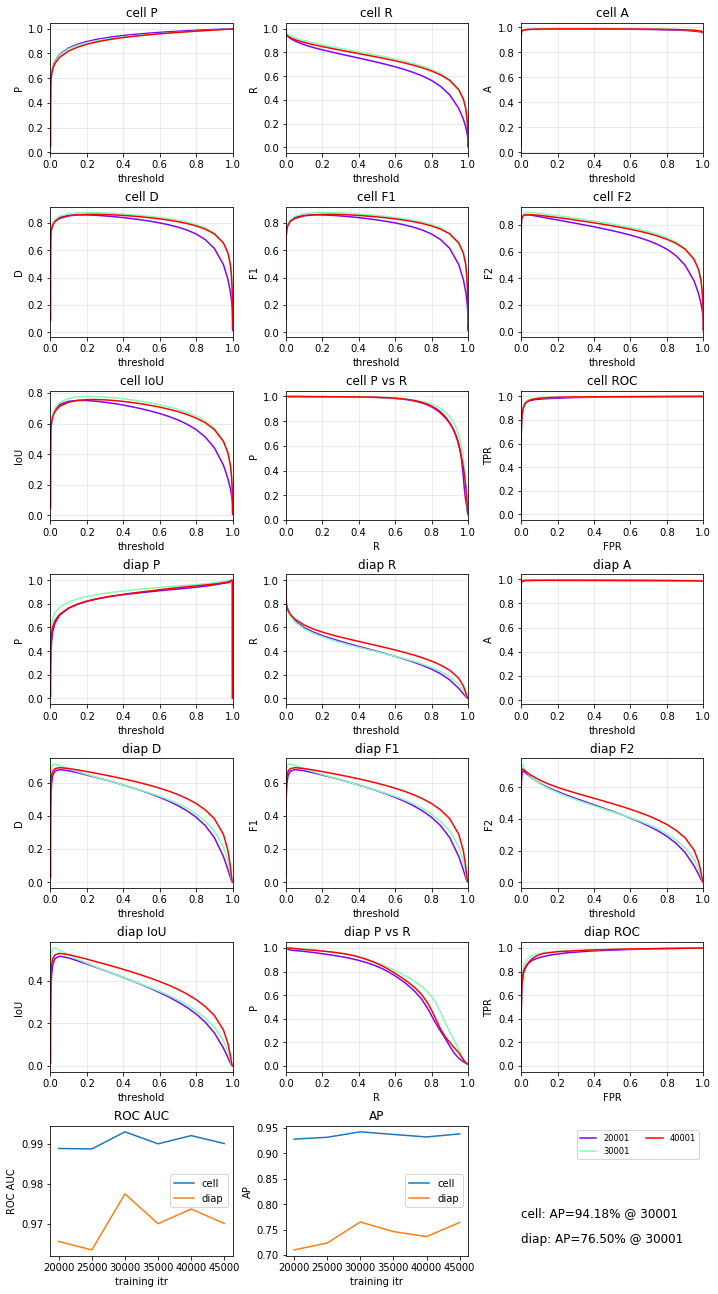

<Figure size 432x288 with 0 Axes>

In [640]:
mean_pix_metr = pix_perf_summ['mean_pix_metr']
pix_metr_agg = pix_perf_summ['pix_metr_agg']

plot_pix_mean_metr(mean_pix_metr, pix_metr_agg, merge=True)

# tests

In [2]:
t_str = '2021.04.06_18-19'  # ref3
valid_summary_name = 'BBB/model_BBB_BN_TV_FCNx16_HN_CDC_%s/valid_summ.pckl' % t_str

In [ ]:
with open(valid_summary_name, 'rb') as handle:
    val_summ = pickle.load(handle)

In [ ]:
%%time
pix_metr = get_pix_metr(val_summ)

In [ ]:
%%time
pix_metr_agg = get_pix_metr_agg(val_summ)

In [253]:
%%time
mean_pix_metr = get_mean_pix_metr(pix_metr)

In [284]:
%%time
plot_pix_mean_metr(mean_pix_metr, pix_metr_agg, merge=True, save_sfx=t_str, show=False)

CPU times: user 2.8 s, sys: 616 ms, total: 3.42 s
Wall time: 3.17 s


<Figure size 432x288 with 0 Axes>

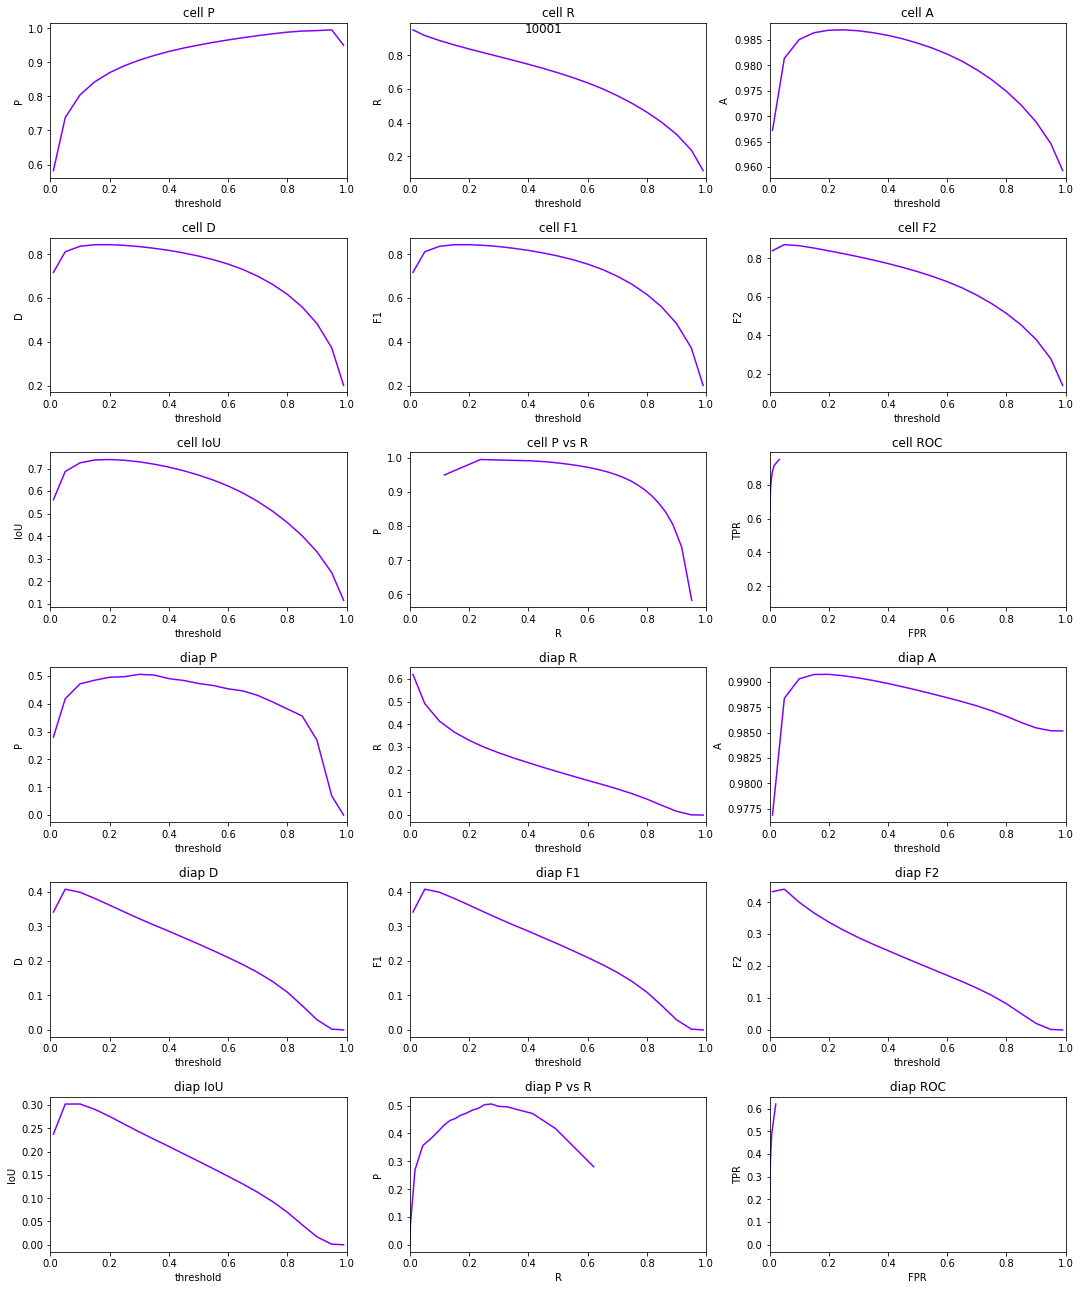

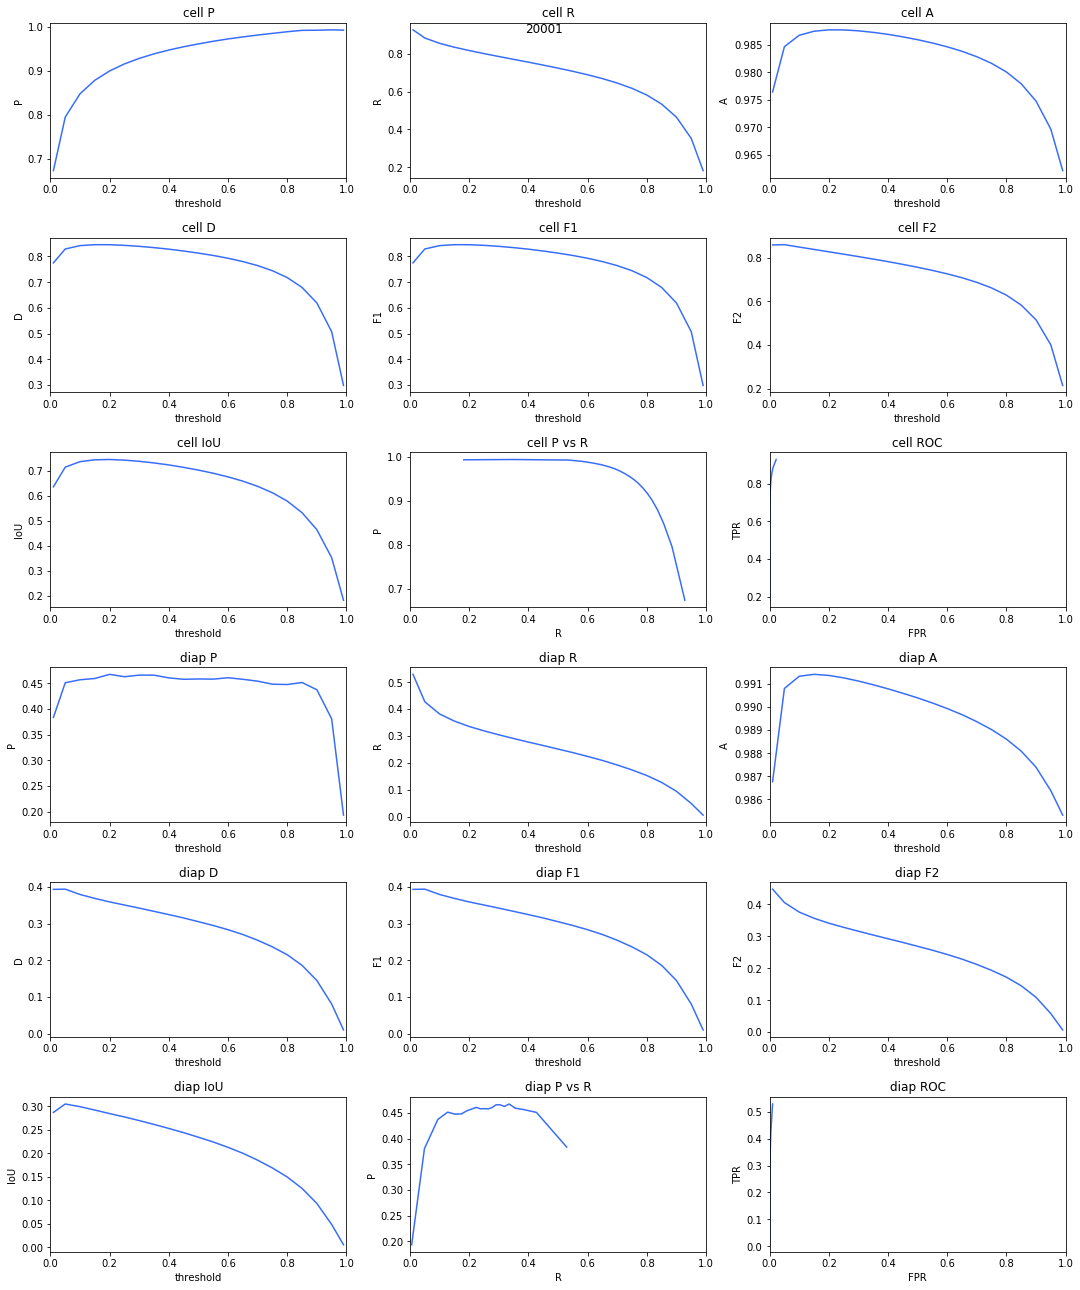

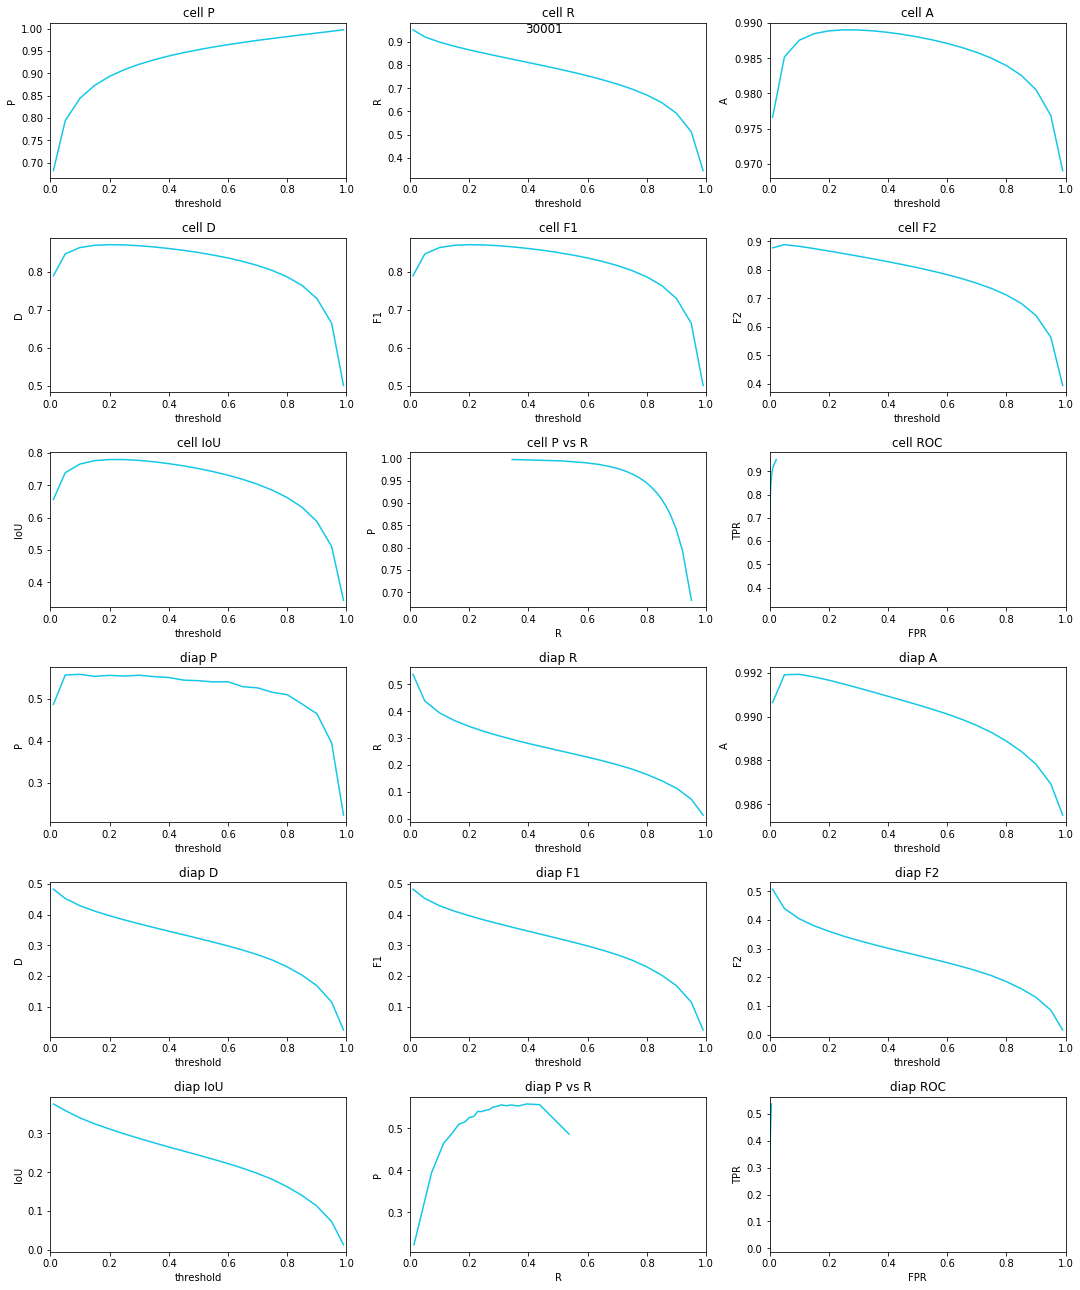

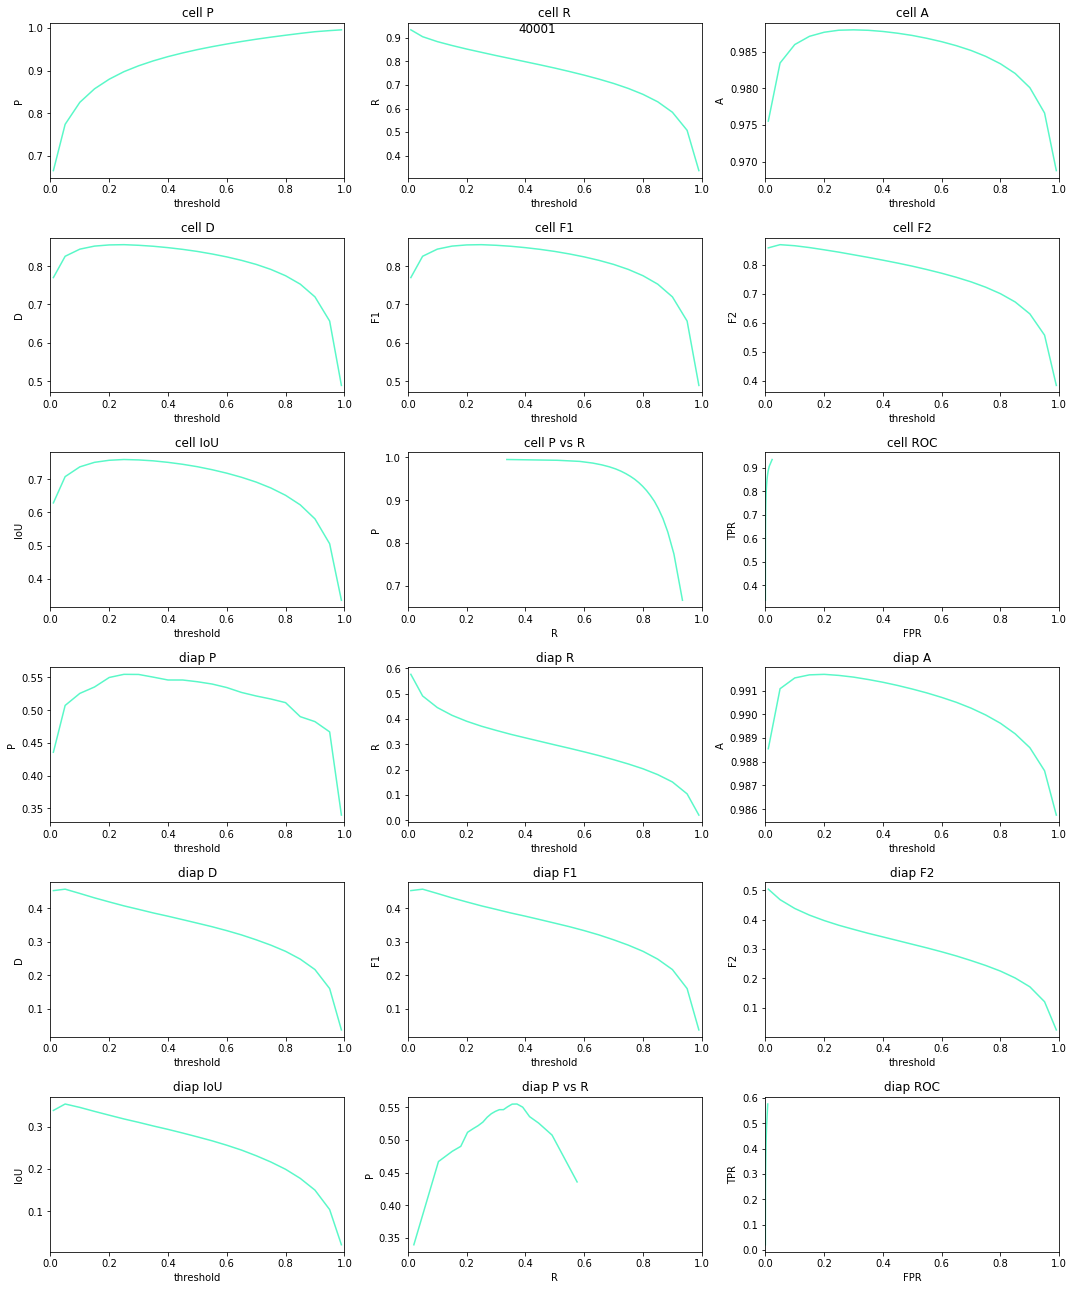

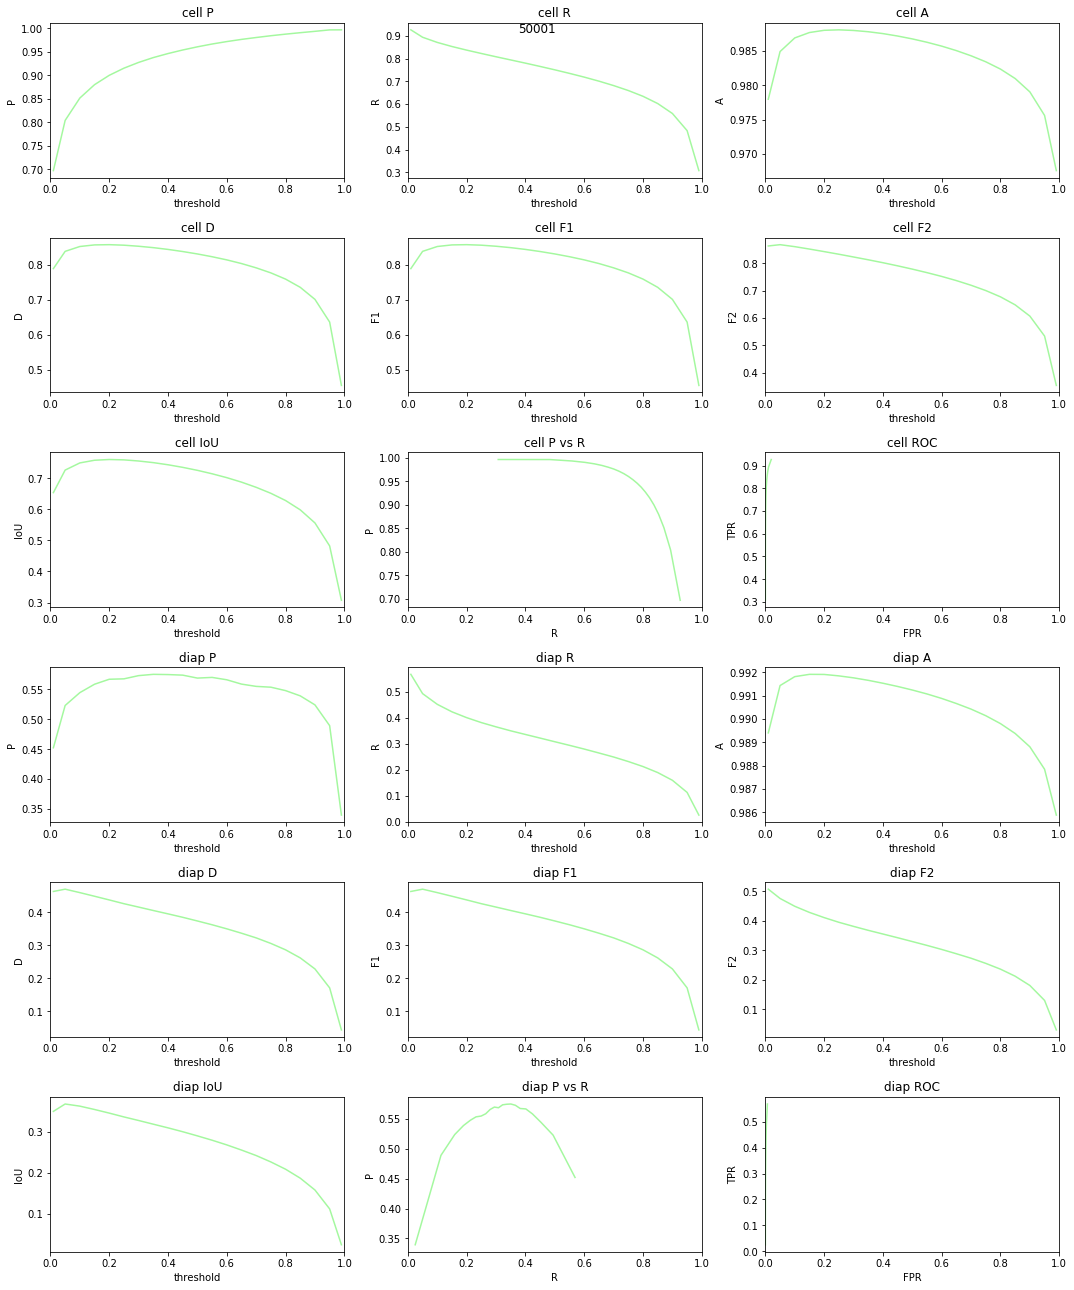

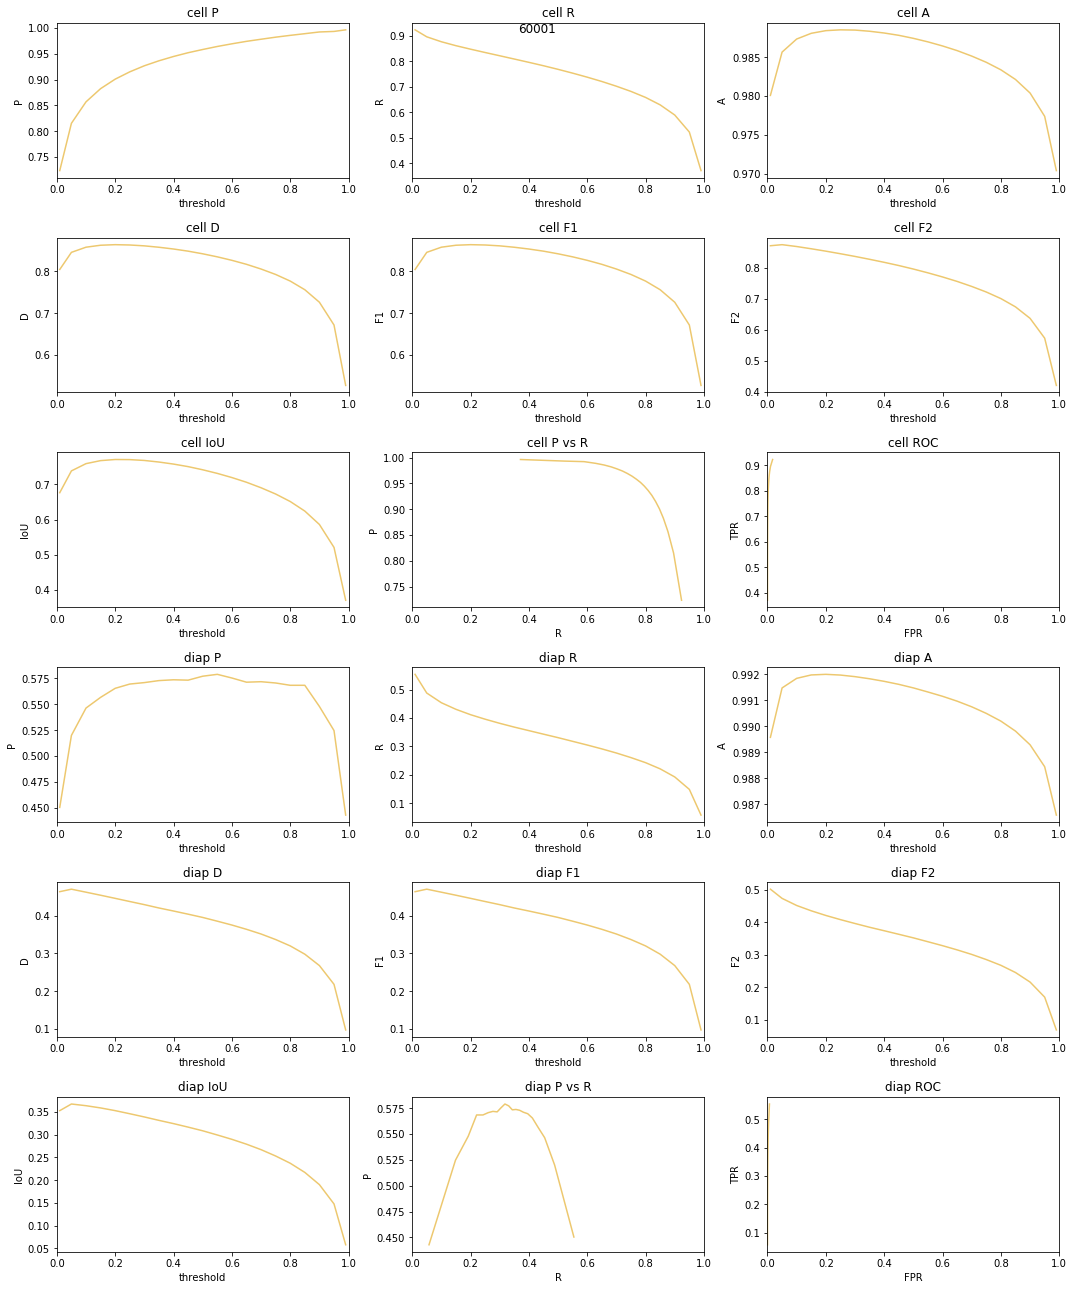

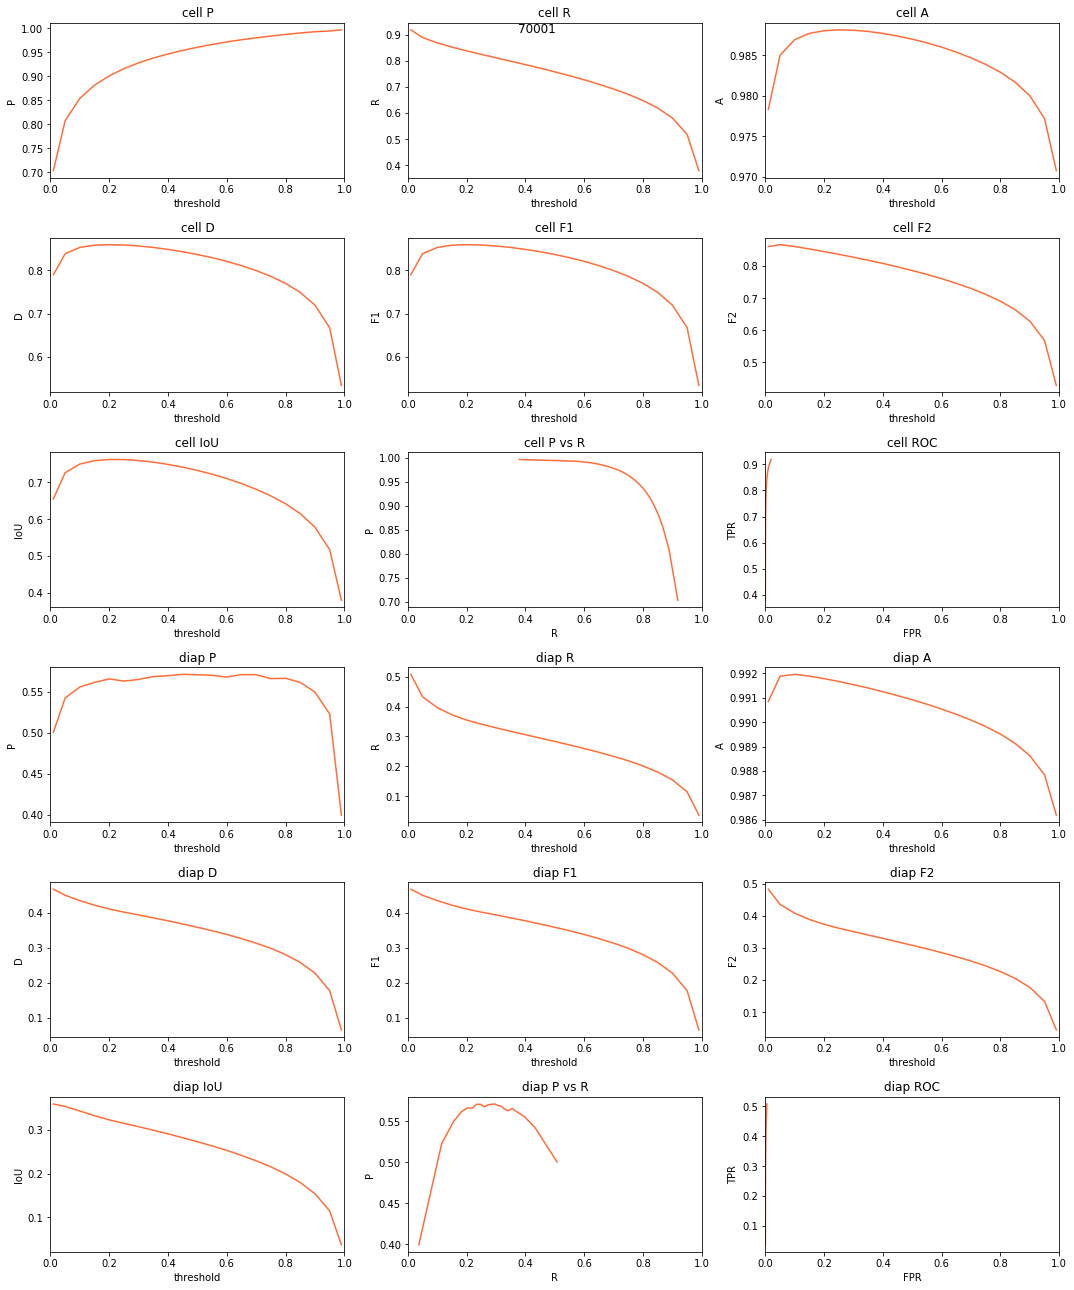

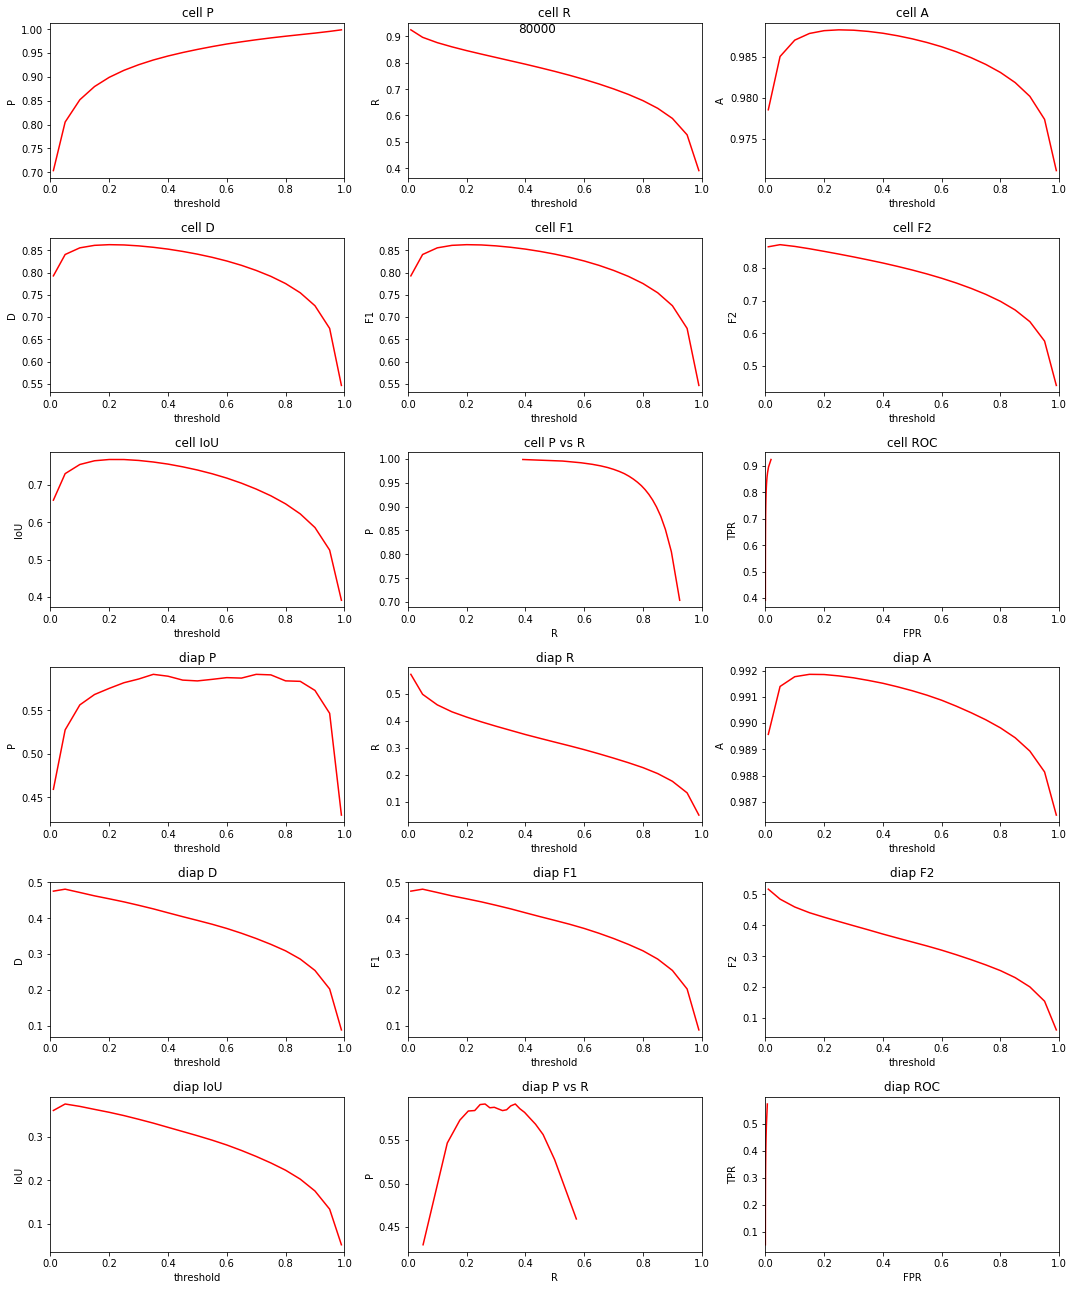

<Figure size 432x288 with 0 Axes>

In [229]:
plot_pix_mean_metr(mean_pix_metr)

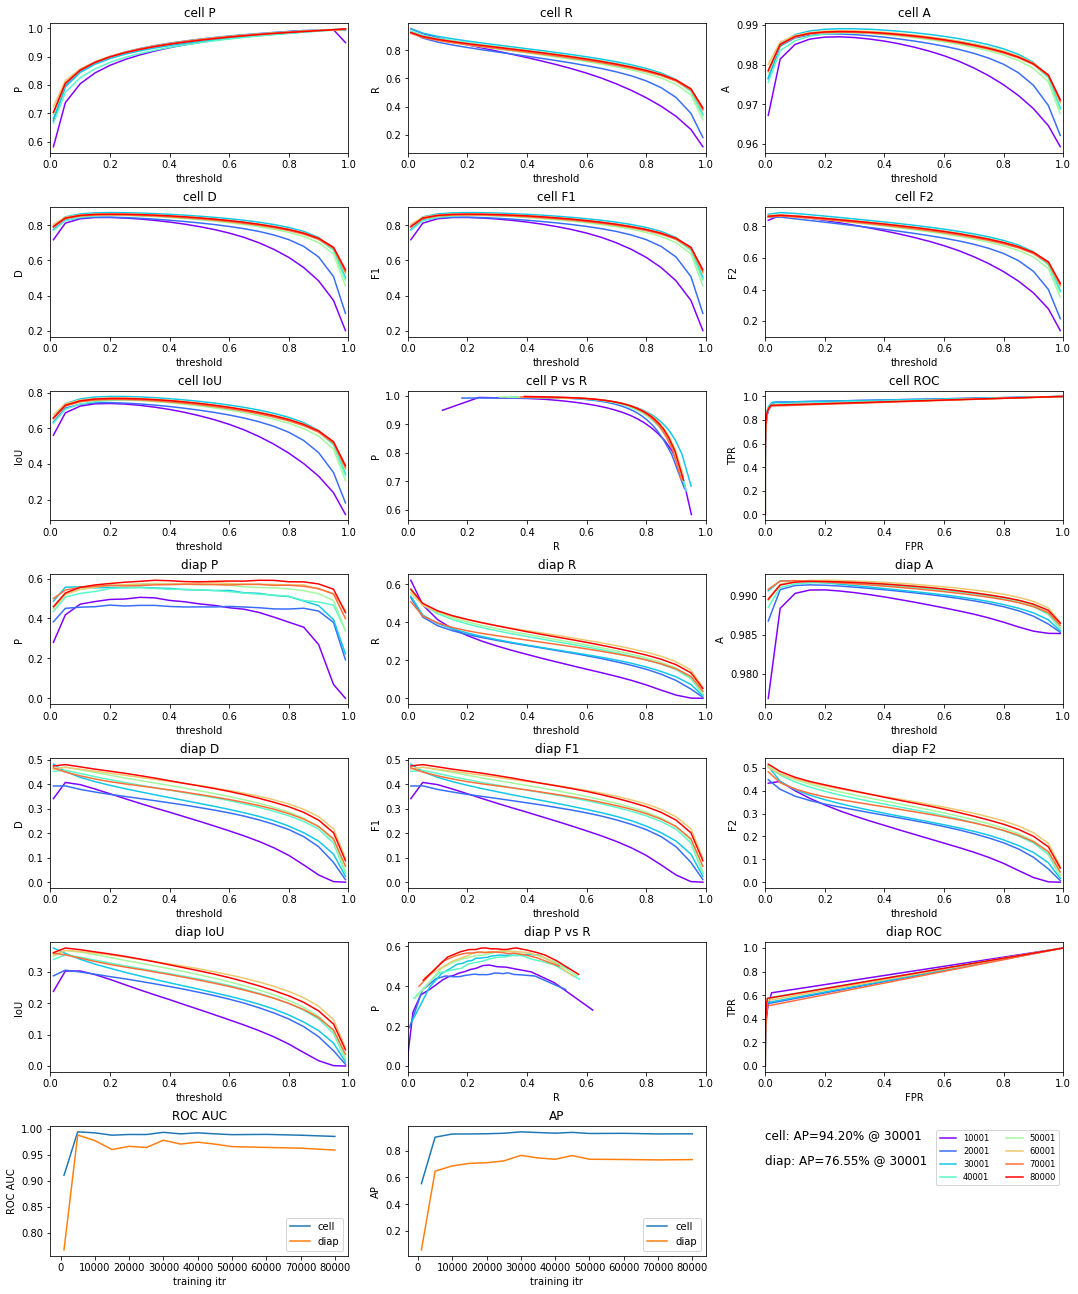

<Figure size 432x288 with 0 Axes>

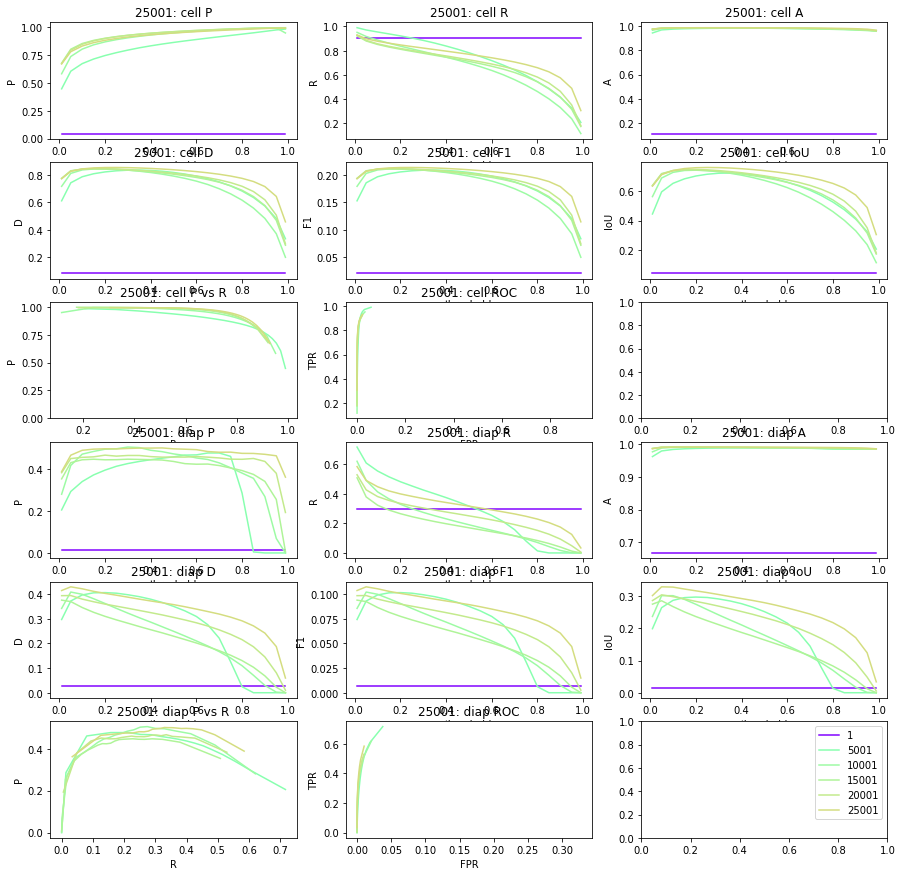

<Figure size 432x288 with 0 Axes>

In [174]:
plot_pix_mean_metr(mean_pix_metr, merge=True)

# run 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars


	 cell: AP=93.12% @ 25001
	 diap: AP=72.37% @ 25001


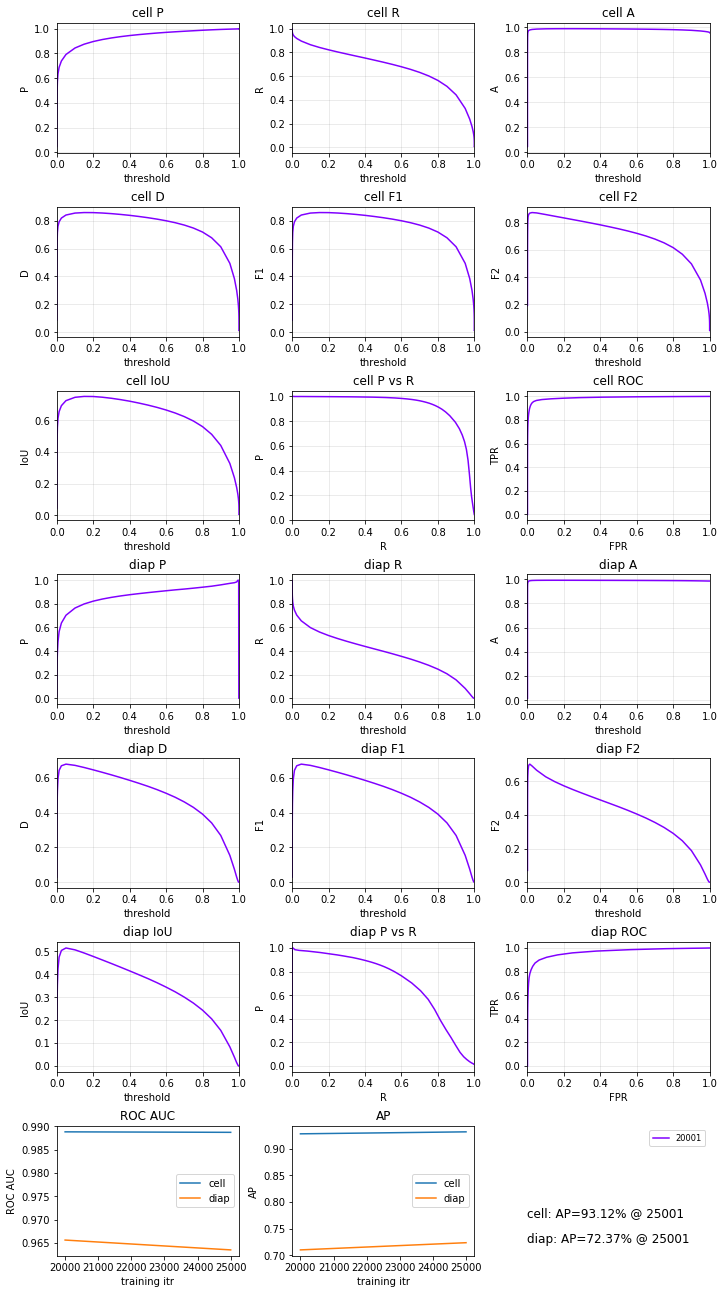

CPU times: user 1min 53s, sys: 49.8 s, total: 2min 43s
Wall time: 2min 41s


<Figure size 432x288 with 0 Axes>

In [10]:
%%time
pix_perf_summ = gen_metrics('2021.04.06_18-19', 'ref3_lr5e-4', show=True)

In [632]:
#print class percentage

#pix_perf_summ = load_metrics('2021.04.06_18-19', 'ref3_lr5e-4_dbg')
n_cell_pix, n_diap_pix, n_tot_pix = pix_perf_summ['n_cell_pix'], pix_perf_summ['n_diap_pix'], pix_perf_summ['n_tot_pix']

cell_frac = n_cell_pix/n_tot_pix
diap_frac = n_diap_pix/n_tot_pix
print(f'imabalance: \n\tcells: {cell_frac*100:.2f}% \n\tdiaps: {diap_frac*100:.2f}%')

imabalance: 
	cells: 4.51% 
	diaps: 1.48%


# run many

In [10]:
%%time
t_str__info = {
    '2021.04.06_18-19': 'ref3_lr5e-4',
    '2021.04.06_18-26': 'ref5_lr5e-4',
    '2021.04.06_18-28': 'ref7_lr5e-4',
    '2021.04.06_18-31': 'ref8_lr5e-4',
    
    '2021.04.09_21-26': 'ref7_lr1.66e-4',
    '2021.04.09_21-23': 'ref7_lr5e-4',
    '2021.04.09_21-20': 'ref7_lr1.5e-3',
    '2021.04.09_21-18': 'ref7_lr4.5e-3',
    '2021.04.14_10-47': 'ref7_lr1.35e-2',
    '2021.04.14_10-44': 'ref7_lr4.19e-1',
}

for t_str, info in t_str__info.items():
    print(f'\n{t_str}, {info}')
    gen_metrics(t_str, info)


2021.04.06_18-19, ref3_lr5e-4
	 cell: AP=94.18% @ 30001 80000
	 diap: AP=76.50% @ 30001

2021.04.06_18-26, ref5_lr5e-4
	 cell: AP=94.96% @ 45001 80000
	 diap: AP=80.57% @ 45001

2021.04.06_18-28, ref7_lr5e-4
	 cell: AP=95.22% @ 30001 80000
	 diap: AP=80.52% @ 35001

2021.04.06_18-31, ref8_lr5e-4
	 cell: AP=94.87% @ 30001 80000
	 diap: AP=80.81% @ 30001

2021.04.09_21-26, ref7_lr1.66e-4
	 cell: AP=94.58% @ 25001 90000
	 diap: AP=80.15% @ 25001

2021.04.09_21-23, ref7_lr5e-4
	 cell: AP=94.27% @ 30001 90000
	 diap: AP=78.59% @ 30001

2021.04.09_21-20, ref7_lr1.5e-3
	 cell: AP=94.94% @ 30001 90000
	 diap: AP=81.86% @ 30001

2021.04.09_21-18, ref7_lr4.5e-3
	 cell: AP=94.56% @ 20001 90000
	 diap: AP=79.89% @ 20001

2021.04.14_10-47, ref7_lr1.35e-2
	 cell: AP=95.13% @ 45001 90000
	 diap: AP=81.86% @ 45001

2021.04.14_10-44, ref7_lr4.19e-1
	 cell: AP=94.36% @ 70001 90000
	 diap: AP=78.50% @ 70001


<Figure size 432x288 with 0 Axes>

In [19]:
# prod 3 runs
%%time
t_str__info = {
    '2021.07.06_16-22': 'R1_ref7_lr1.5e-3',
    '2021.07.06_16-25': 'R2_ref7_lr1.5e-3',
    '2021.07.06_16-28': 'R3_ref7_lr1.5e-3',
}

for t_str, info in t_str__info.items():
    print(f'\n{t_str}, {info}')
    gen_metrics(t_str, info)


2021.07.06_16-22, R1_ref7_lr1.5e-3
	 cell: AP=94.93% @ 35001 40000
	 diap: AP=81.10% @ 35001

2021.07.06_16-25, R2_ref7_lr1.5e-3
	 cell: AP=95.26% @ 25001 40000
	 diap: AP=82.74% @ 35001

2021.07.06_16-28, R3_ref7_lr1.5e-3
	 cell: AP=94.95% @ 35001 40000
	 diap: AP=81.37% @ 35001
CPU times: user 14min 59s, sys: 2min 44s, total: 17min 44s
Wall time: 17min 41s


<Figure size 432x288 with 0 Axes>

In [26]:
pix_perf_summ = load_metrics('2021.04.06_18-19', 'ref3_lr5e-4')
mean_pix_metr = pix_perf_summ['mean_pix_metr']
pix_metr_agg = pix_perf_summ['pix_metr_agg']

plot_pix_mean_metr(mean_pix_metr, pix_metr_agg,
                   merge=True, save_sfx=f'2021.04.06_18-19_ref3_lr5e-4_new',
                   show=False
                  )

	 cell: AP=94.18% @ 30001
	 diap: AP=76.50% @ 30001


<Figure size 432x288 with 0 Axes>

In [26]:
pix_perf_summ = load_metrics(f'BBB_metrics/2021.07.06_16-25', info='R2_ref7_lr1.5e-3')
tr_it = 35001
mtr_agg = pix_perf_summ['pix_metr_agg'][tr_it]
print(f'cell AP =', mtr_agg['cell']['pr_auc_t'])
print(f'diap AP =', mtr_agg['diap']['pr_auc_t'])

cell AP = 0.9525335808882944
diap AP = 0.8274494149860722


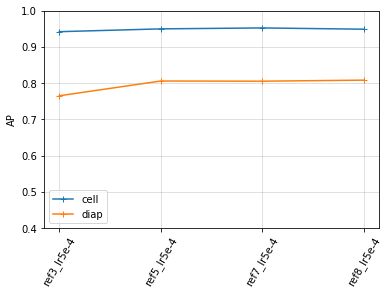

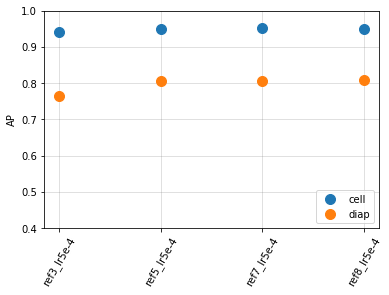

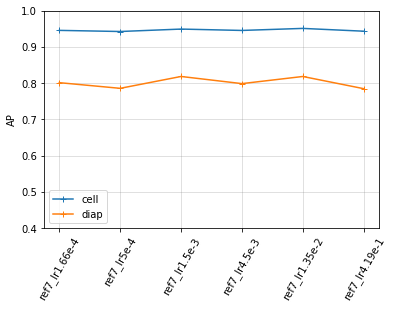

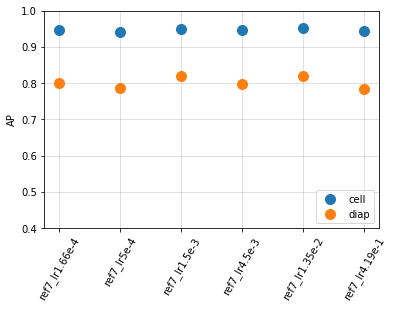

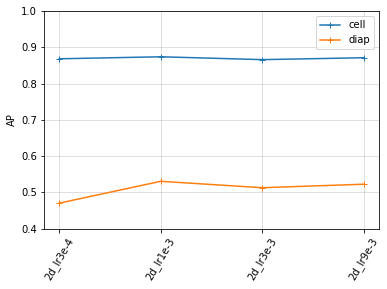

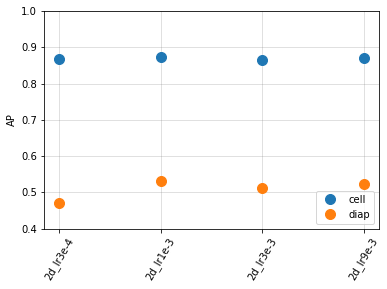

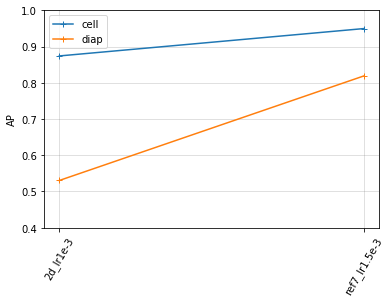

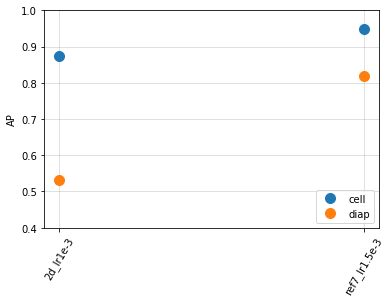

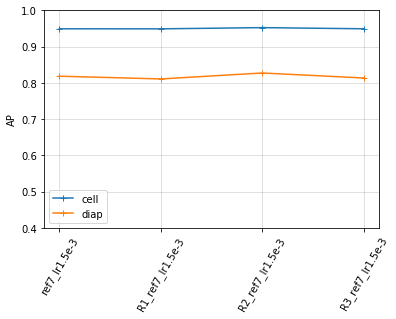

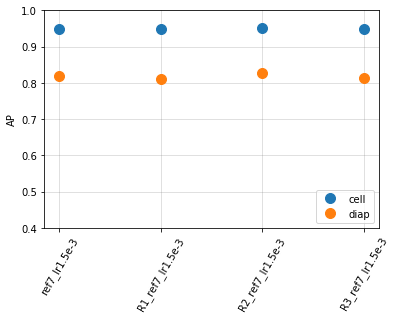

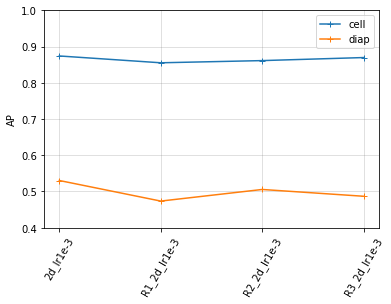

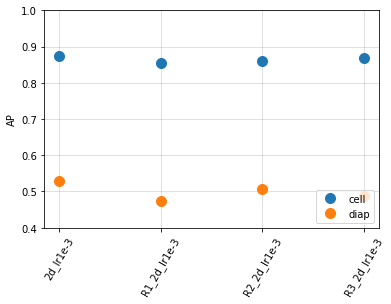

In [22]:
t_str__infos = [{
    '2021.04.06_18-19': 'ref3_lr5e-4',
    '2021.04.06_18-26': 'ref5_lr5e-4',
    '2021.04.06_18-28': 'ref7_lr5e-4',
    '2021.04.06_18-31': 'ref8_lr5e-4',
},
{
    '2021.04.09_21-26': 'ref7_lr1.66e-4',
    '2021.04.09_21-23': 'ref7_lr5e-4',
    '2021.04.09_21-20': 'ref7_lr1.5e-3',
    '2021.04.09_21-18': 'ref7_lr4.5e-3',
    '2021.04.14_10-47': 'ref7_lr1.35e-2',
    '2021.04.14_10-44': 'ref7_lr4.19e-1',
},
{
    '2021.04.17_22-58': '2d_lr3e-4', 
    '2021.04.17_22-54': '2d_lr1e-3', 
    '2021.04.17_23-00': '2d_lr3e-3', 
    '2021.04.20_18-25': '2d_lr9e-3',
},
{
    '2021.04.17_22-54': '2d_lr1e-3', 
    '2021.04.09_21-20': 'ref7_lr1.5e-3',
},
{
    '2021.04.09_21-20': 'ref7_lr1.5e-3',
    '2021.07.06_16-22': 'R1_ref7_lr1.5e-3',
    '2021.07.06_16-25': 'R2_ref7_lr1.5e-3',
    '2021.07.06_16-28': 'R3_ref7_lr1.5e-3',
},
{
    '2021.04.17_22-54': '2d_lr1e-3',
    '2021.07.06_16-22': 'R1_2d_lr1e-3',
    '2021.07.06_16-25': 'R2_2d_lr1e-3',
    '2021.07.06_16-28': 'R3_2d_lr1e-3',
}
]

for t_str__info in t_str__infos:

    models_max_ap_cell = []
    models_max_ap_diap = []
    for t_str, info in t_str__info.items():
        #print(f'\n{t_str}, {info}')
        cell_ap_all = []
        diap_ap_all = []
        tr_its = []

        pix_perf_summ = load_metrics(f'BBB_metrics/{t_str}', info)
        for tr_it, mtr_agg in pix_perf_summ['pix_metr_agg'].items():
            tr_its.append(tr_it)
            cell_ap_all.append(mtr_agg['cell']['pr_auc_t'])
            diap_ap_all.append(mtr_agg['diap']['pr_auc_t'])

        cell_ap_max = np.max(cell_ap_all)
        diap_ap_max = np.max(diap_ap_all)

        models_max_ap_cell.append(cell_ap_max)
        models_max_ap_diap.append(diap_ap_max)

    ticks_lbl = list(t_str__info.values())
    ticks_idx = np.arange(len(ticks_lbl))
    plt.plot(ticks_idx, models_max_ap_cell, '-+', label='cell')
    plt.plot(ticks_idx, models_max_ap_diap, '-+', label='diap')

    plt.xticks(ticks_idx, ticks_lbl, rotation=60, )
    plt.ylim(0.4, 1)
    plt.grid(c='gray', alpha=0.3)
    plt.legend()
    plt.ylabel('AP')
    plt.show()
    
    plt.plot(ticks_idx, models_max_ap_cell, '.', markersize=20, label='cell')
    plt.plot(ticks_idx, models_max_ap_diap, '.', markersize=20, label='diap')

    plt.xticks(ticks_idx, ticks_lbl, rotation=60, )
    plt.ylim(0.4, 1)
    plt.grid(c='gray', alpha=0.3)
    plt.legend(loc='lower right')
    plt.ylabel('AP')
    plt.show()

In [56]:
t_str__info = {'2021.04.09_21-20': 'ref7_lr1.5e-3'}
for t_str, info in t_str__info.items():
    pix_perf_summ = load_metrics(f'BBB_metrics/{t_str}', info)
    
tr_it = 30001
p = 0.30000000000000004
for tp in ['cell', 'diap']:
    for d in ['P', 'R', 'F1', 'IoU']:
        v = pix_perf_summ['mean_pix_metr'][tr_it][tp][p][d]
        print(tp, d, f'{v*100:.2f}%')
        

cell P 89.21%
cell R 86.63%
cell F1 87.90%
cell IoU 78.41%
diap P 82.99%
diap R 65.40%
diap F1 73.15%
diap IoU 57.67%


# Run 2D

In [69]:
valid_summary_name = 'BBB/model_BBB_BN_TV_FCN4_CDC_2D_%s/valid_summ.pckl' %  '2019.11.11_01-11'

with open(valid_summary_name, 'rb') as f:
    val_summ = pickle.load(f)

In [70]:
val_summ['pred'].keys()

dict_keys([1001, 5001, 10001, 15001, 20001, 25001, 30001, 35001, 40001, 45001, 50001, 60001, 70001, 80001, 90001, 100000])

In [71]:
t_str__info = {
    '2019.11.11_01-11': '2d19_lr1e-3',
}

for t_str, info in t_str__info.items():
    print(f'\n{t_str}, {info}')
    gen_metrics(t_str, info, root_name='model_BBB_BN_TV_FCN4_CDC_2D')


2019.11.11_01-11, 2d19_lr1e-3
	 cell: AP=95.42% @ 100000 00000
	 diap: AP=84.70% @ 90001


<Figure size 432x288 with 0 Axes>

In [ ]:
%%time

t_str__info = {
    '2021.04.17_22-58': '2d_lr3e-4',
    '2021.04.17_22-54': '2d_lr1e-3',
    '2021.04.17_23-00': '2d_lr3e-3',
    '2021.04.20_18-25': '2d_lr9e-3',
}

for t_str, info in t_str__info.items():
    print(f'\n{t_str}, {info}')
    gen_metrics(t_str, info, root_name='model_BBB_BN_TV_FCN4_HN_CDC_2D')


2021.04.17_22-58, 2d_lr3e-4
	 cell: AP=86.84% @ 800010 00000
	 diap: AP=47.01% @ 70001

2021.04.17_22-54, 2d_lr1e-3
	 cell: AP=87.40% @ 300010 00000
	 diap: AP=53.03% @ 30001

2021.04.17_23-00, 2d_lr3e-3


In [29]:
%%time

t_str__info = {
    '2021.04.20_18-25': '2d_lr9e-3',
}

for t_str, info in t_str__info.items():
    print(f'\n{t_str}, {info}')
    gen_metrics(t_str, info, root_name='model_BBB_BN_TV_FCN4_HN_CDC_2D')


2021.04.20_18-25, 2d_lr9e-3
	 cell: AP=87.13% @ 25000 25000
	 diap: AP=52.23% @ 15001
CPU times: user 3min 32s, sys: 39.3 s, total: 4min 11s
Wall time: 4min 11s


<Figure size 432x288 with 0 Axes>

In [20]:
%%time

t_str__info = {
    '2021.07.06_16-22': 'R1_2d_lr1e-3',
    '2021.07.06_16-25': 'R2_2d_lr1e-3',
    '2021.07.06_16-28': 'R3_2d_lr1e-3',
}

for t_str, info in t_str__info.items():
    print(f'\n{t_str}, {info}')
    gen_metrics(t_str, info, root_name='model_BBB_BN_TV_FCN4_HN_CDC_2D')


2021.07.06_16-22, R1_2d_lr1e-3
	 cell: AP=85.52% @ 25001 40000
	 diap: AP=47.35% @ 25001

2021.07.06_16-25, R2_2d_lr1e-3
	 cell: AP=86.12% @ 35001 40000
	 diap: AP=50.56% @ 35001

2021.07.06_16-28, R3_2d_lr1e-3
	 cell: AP=86.96% @ 20001 40000
	 diap: AP=48.68% @ 20001
CPU times: user 16min 44s, sys: 2min 42s, total: 19min 27s
Wall time: 19min 27s


<Figure size 432x288 with 0 Axes>

# Save best itr plots

In [24]:
t_str__info = [
    ('2021.04.06_18-19', 'ref3_lr5e-4'),
    ('2021.04.06_18-26', 'ref5_lr5e-4'),
    ('2021.04.06_18-28', 'ref7_lr5e-4'),
    ('2021.04.06_18-31', 'ref8_lr5e-4'),

    ('2021.04.09_21-26', 'ref7_lr1.66e-4'),
    ('2021.04.09_21-23', 'ref7_lr5e-4'),
    ('2021.04.09_21-18', 'ref7_lr4.5e-3'),
    ('2021.04.09_21-20', 'ref7_lr1.5e-3'),
    ('2021.04.14_10-47', 'ref7_lr1.35e-2'),
    ('2021.04.14_10-44', 'ref7_lr4.19e-1'),

    ('2021.04.17_22-58', '2d_lr3e-4'),
    ('2021.04.17_22-54', '2d_lr1e-3'),
    ('2021.04.17_23-00', '2d_lr3e-3'),
    ('2021.04.20_18-25', '2d_lr9e-3'),
    
    ('2021.07.06_16-22', 'R1_ref7_lr1.5e-3'),
    ('2021.07.06_16-25', 'R2_ref7_lr1.5e-3'),
    ('2021.07.06_16-28', 'R3_ref7_lr1.5e-3'),

    ('2021.07.06_16-22', 'R1_2d_lr1e-3'),
    ('2021.07.06_16-25', 'R2_2d_lr1e-3'),
    ('2021.07.06_16-28', 'R3_2d_lr1e-3'),
]

for t_str, info in t_str__info:
    print(f'\n{t_str}, {info}')
    
    pix_perf_summ = load_metrics(f'BBB_metrics/{t_str}', info)
    mean_pix_metr = pix_perf_summ['mean_pix_metr']
    pix_metr_agg = pix_perf_summ['pix_metr_agg']

    plot_pix_mean_metr(mean_pix_metr, pix_metr_agg, merge=True, save_sfx=f'{t_str}_{info}',show=False, best=True)
    plot_pix_mean_metr(mean_pix_metr, pix_metr_agg, merge=True, save_sfx=f'{t_str}_{info}',show=False)
    # plot_pix_mean_metr(mean_pix_metr, pix_metr_agg, merge=True, show=True, best=True)
    
    


2021.04.06_18-19, ref3_lr5e-4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.18% @ 30001
	 diap: AP=76.50% @ 30001
	 cell: AP=94.18% @ 30001
	 diap: AP=76.50% @ 30001

2021.04.06_18-26, ref5_lr5e-4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.96% @ 45001
	 diap: AP=80.57% @ 45001
	 cell: AP=94.96% @ 45001
	 diap: AP=80.57% @ 45001

2021.04.06_18-28, ref7_lr5e-4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=95.22% @ 30001
	 diap: AP=80.52% @ 35001
	 cell: AP=95.22% @ 30001
	 diap: AP=80.52% @ 35001

2021.04.06_18-31, ref8_lr5e-4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.87% @ 30001
	 diap: AP=80.81% @ 30001
	 cell: AP=94.87% @ 30001
	 diap: AP=80.81% @ 30001

2021.04.09_21-26, ref7_lr1.66e-4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.58% @ 25001
	 diap: AP=80.15% @ 25001
	 cell: AP=94.58% @ 25001
	 diap: AP=80.15% @ 25001

2021.04.09_21-23, ref7_lr5e-4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.27% @ 30001
	 diap: AP=78.59% @ 30001
	 cell: AP=94.27% @ 30001
	 diap: AP=78.59% @ 30001

2021.04.09_21-18, ref7_lr4.5e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.56% @ 20001
	 diap: AP=79.89% @ 20001
	 cell: AP=94.56% @ 20001
	 diap: AP=79.89% @ 20001

2021.04.09_21-20, ref7_lr1.5e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.94% @ 30001
	 diap: AP=81.86% @ 30001
	 cell: AP=94.94% @ 30001
	 diap: AP=81.86% @ 30001

2021.04.14_10-47, ref7_lr1.35e-2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=95.13% @ 45001
	 diap: AP=81.86% @ 45001
	 cell: AP=95.13% @ 45001
	 diap: AP=81.86% @ 45001

2021.04.14_10-44, ref7_lr4.19e-1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.36% @ 70001
	 diap: AP=78.50% @ 70001
	 cell: AP=94.36% @ 70001
	 diap: AP=78.50% @ 70001

2021.04.17_22-58, 2d_lr3e-4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=86.84% @ 80001
	 diap: AP=47.01% @ 70001
	 cell: AP=86.84% @ 80001
	 diap: AP=47.01% @ 70001

2021.04.17_22-54, 2d_lr1e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=87.40% @ 30001
	 diap: AP=53.03% @ 30001
	 cell: AP=87.40% @ 30001
	 diap: AP=53.03% @ 30001

2021.04.17_23-00, 2d_lr3e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=86.61% @ 15001
	 diap: AP=51.27% @ 15001
	 cell: AP=86.61% @ 15001
	 diap: AP=51.27% @ 15001

2021.04.20_18-25, 2d_lr9e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=87.13% @ 25000
	 diap: AP=52.23% @ 15001
	 cell: AP=87.13% @ 25000
	 diap: AP=52.23% @ 15001

2021.07.06_16-22, R1_ref7_lr1.5e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.93% @ 35001
	 diap: AP=81.10% @ 35001
	 cell: AP=94.93% @ 35001
	 diap: AP=81.10% @ 35001

2021.07.06_16-25, R2_ref7_lr1.5e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=95.26% @ 25001
	 diap: AP=82.74% @ 35001
	 cell: AP=95.26% @ 25001
	 diap: AP=82.74% @ 35001

2021.07.06_16-28, R3_ref7_lr1.5e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=94.95% @ 35001
	 diap: AP=81.37% @ 35001
	 cell: AP=94.95% @ 35001
	 diap: AP=81.37% @ 35001

2021.07.06_16-22, R1_2d_lr1e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=85.52% @ 25001
	 diap: AP=47.35% @ 25001
	 cell: AP=85.52% @ 25001
	 diap: AP=47.35% @ 25001

2021.07.06_16-25, R2_2d_lr1e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=86.12% @ 35001
	 diap: AP=50.56% @ 35001
	 cell: AP=86.12% @ 35001
	 diap: AP=50.56% @ 35001

2021.07.06_16-28, R3_2d_lr1e-3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


	 cell: AP=86.96% @ 20001
	 diap: AP=48.68% @ 20001
	 cell: AP=86.96% @ 20001
	 diap: AP=48.68% @ 20001


<Figure size 432x288 with 0 Axes>